In [107]:
# Dependencies
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import matplotlib.dates as mdates
import numpy as np
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text

In [108]:
# Read the CSV files
csv_file = '../data/store.csv'

# Save CSV files into DataFrame
df = pd.read_csv(csv_file)

# Display DataFrame
df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [109]:
# Select the first 20 rows (or all rows if there are fewer than 20)
top_20_rows = df.head(20)

# Convert the selected rows to an HTML table
html_table = top_20_rows.to_html()

# Save the HTML table to a file
with open('../app/templates/table.html', 'w') as file:
    file.write(html_table)

In [110]:
# Change date column to datetime format
df['date'] = pd.to_datetime(df['date'])

In [111]:
# Extract the year from the date column and create a new 'year' column
df['year'] = df['date'].dt.year

# Group by year and calculate the total sales
yearly_sales = df.groupby('year')['sales'].sum().reset_index()

In [112]:
# Define a function to format the y-axis tick labels in millions
def millions_formatter(x, pos):
    return f'{x / 1_000_000:.1f}M'

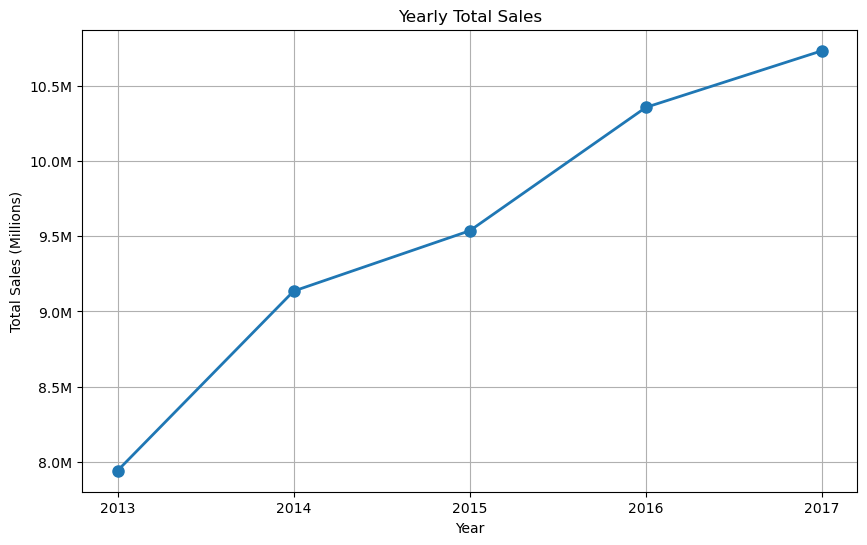

In [113]:
# Plot yearly total sales using Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(yearly_sales['year'], yearly_sales['sales'], marker='o', linestyle='-', linewidth=2, markersize=8)

# Set the y-axis labels to millions
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))

# Set the x-axis to display whole years only
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.set_xlabel('Year')
ax.set_ylabel('Total Sales (Millions)')
ax.set_title('Yearly Total Sales')
ax.grid(True)
plt.show()

In [114]:
# Extract the year and month from the date column and create new columns
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Group by year and month and calculate the total sales
monthly_sales = df.groupby(['year', 'month'])['sales'].sum().reset_index()

In [115]:
# Create a new column with a datetime format, which will be used for the x-axis
monthly_sales['year_month'] = pd.to_datetime(monthly_sales[['year', 'month']].assign(day=1))

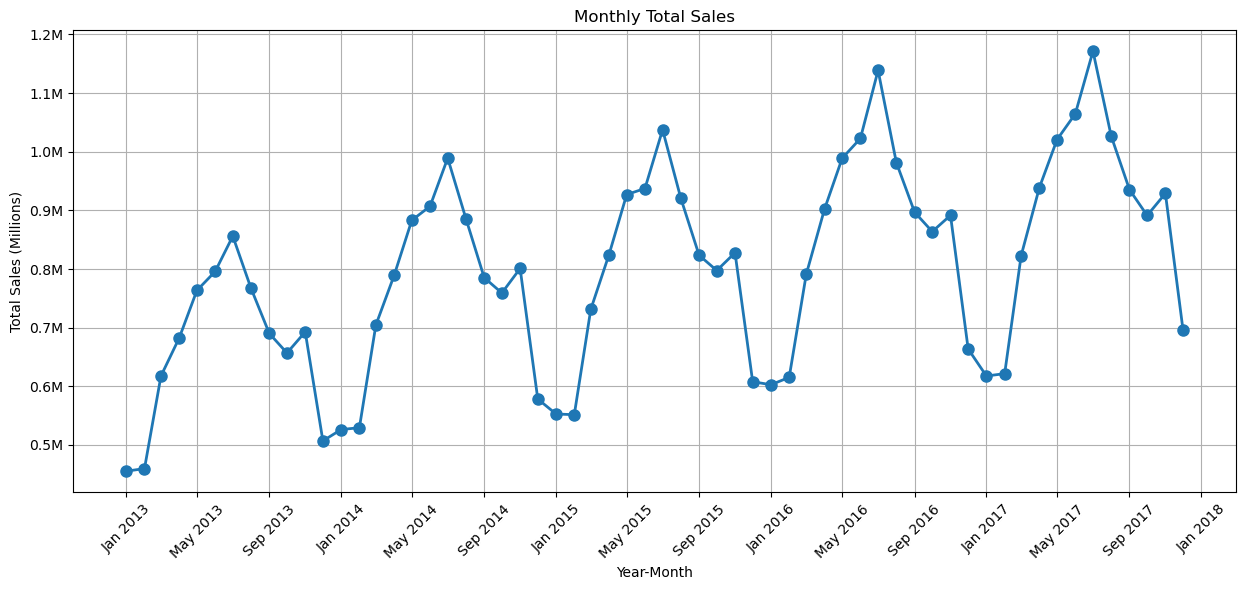

In [116]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(monthly_sales['year_month'], monthly_sales['sales'], marker='o', linestyle='-', linewidth=2, markersize=8)

# Set the y-axis labels to millions
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))

# Format the x-axis labels with short month names and display them every 6 months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

ax.set_xlabel('Year-Month')
ax.set_ylabel('Total Sales (Millions)')
ax.set_title('Monthly Total Sales')
ax.grid(True)
plt.show()

In [117]:
# Calculate the total daily sales
daily_sales = df.groupby('date')['sales'].sum().reset_index()

In [118]:
# Add year, weekday, and weekday name columns
daily_sales['year'] = daily_sales['date'].dt.year
daily_sales['weekday'] = daily_sales['date'].dt.weekday
daily_sales['weekday_name'] = daily_sales['date'].dt.day_name()

# Group by year and weekday, and calculate the average sales
avg_weekday_sales = daily_sales.groupby(['year', 'weekday', 'weekday_name'])['sales'].mean().reset_index()

# Sort by year and weekday
avg_weekday_sales = avg_weekday_sales.sort_values(['year', 'weekday'])


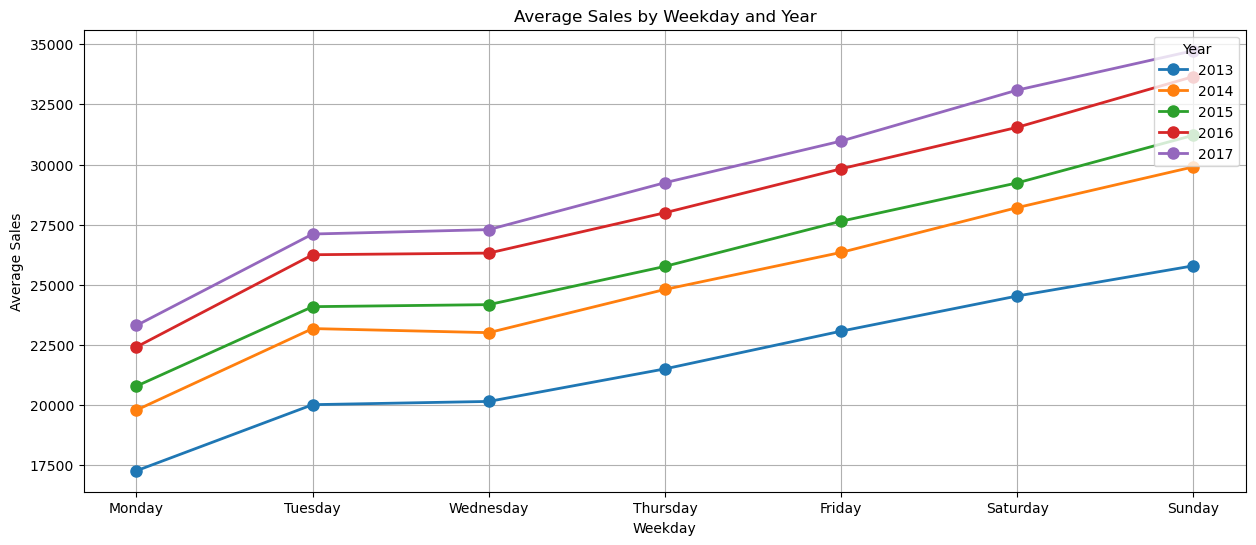

In [119]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot a line for each year with a unique color
years = avg_weekday_sales['year'].unique()
for year in years:
    year_data = avg_weekday_sales[avg_weekday_sales['year'] == year]
    ax.plot(year_data['weekday_name'], year_data['sales'], marker='o', linestyle='-', linewidth=2, markersize=8, label=str(year))

ax.set_xlabel('Weekday')
ax.set_ylabel('Average Sales')
ax.set_title('Average Sales by Weekday and Year')
ax.legend(title='Year', loc='upper right')
ax.grid(True)
plt.show()

In [120]:
# Group by store and calculate the total sales
store_sales = df.groupby('store')['sales'].sum().reset_index()

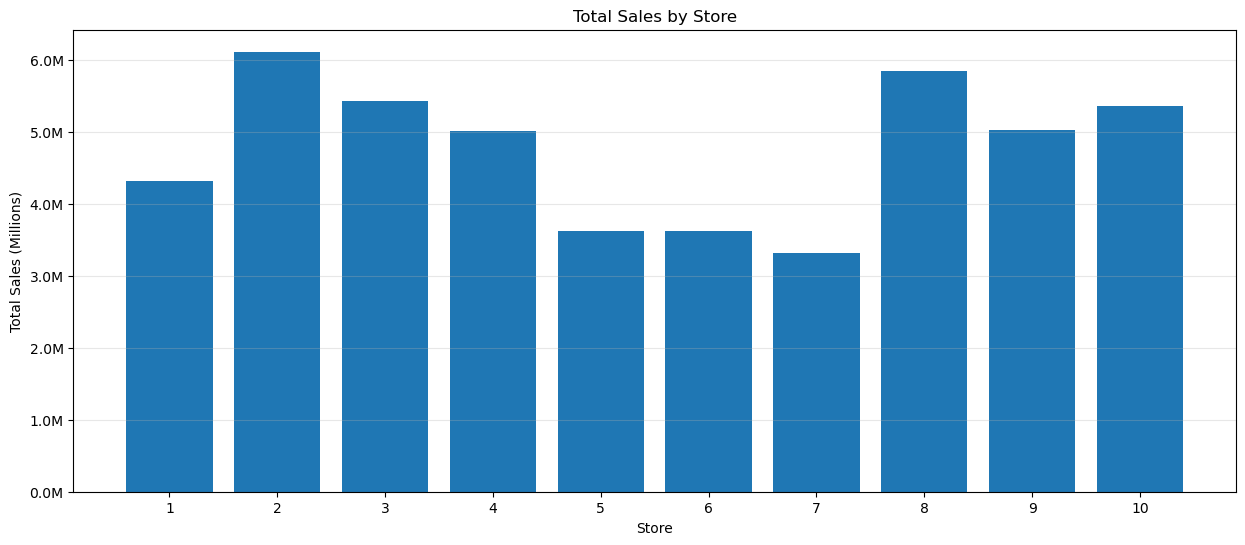

In [121]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(store_sales['store'], store_sales['sales'])

# Set the y-axis labels to millions
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))

ax.set_xlabel('Store')
ax.set_ylabel('Total Sales (Millions)')
ax.set_title('Total Sales by Store')
ax.set_xticks(store_sales['store'])
ax.grid(True, axis='y', alpha=0.3)
plt.show()

In [138]:
store_sales = store_sales.sort_values('sales', ascending=False)
store_sales

,store,sales
1,2,6120128
7,8,5856169
2,3,5435144
9,10,5360158
8,9,5025976
3,4,5012639
0,1,4315603
4,5,3631016
5,6,3627670
6,7,3320009


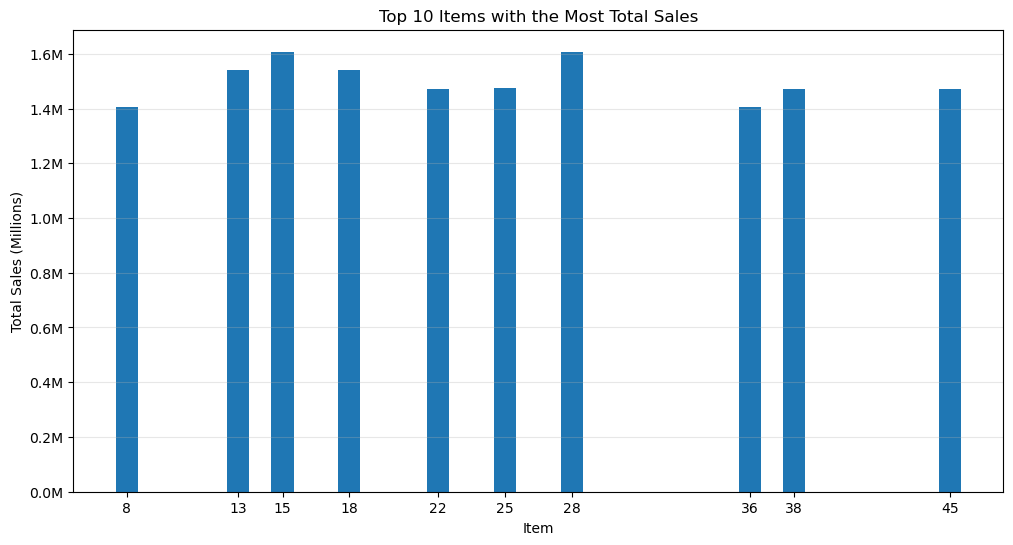

In [139]:
# Group by item and calculate the total sales
item_sales = df.groupby('item')['sales'].sum().reset_index()

item_sales = item_sales.sort_values('sales',ascending=False)

# Select the top 10 items
top_10_items = item_sales.head(10)

# Convert top_10_items back to a DataFrame
top_10_items = top_10_items.reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(top_10_items['item'], top_10_items['sales'], width=1)

# Set the y-axis labels to millions
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))

ax.set_xlabel('Item')
ax.set_ylabel('Total Sales (Millions)')
ax.set_title('Top 10 Items with the Most Total Sales')

# Set the x-axis tick labels and positions to match the top 10 items
ax.set_xticks(top_10_items['item'])
ax.set_xticklabels(top_10_items['item'])

# Set the gridlines to be faint by adjusting the alpha parameter (0 to 1)
ax.grid(True, axis='y', alpha=0.3)

plt.show()

In [140]:
top_10_items = top_10_items.sort_values('sales',ascending=False)
top_10_items

,index,item,sales
0,14,15,1607442
1,27,28,1604713
2,12,13,1539621
3,17,18,1538876
4,24,25,1473334
5,44,45,1471467
6,37,38,1470330
7,21,22,1469971
8,35,36,1406548
9,7,8,1405108


In [141]:
# Connect to local database
protocol = 'postgresql'
username = 'postgres'
password = 'postgres'
host = 'localhost'
port = 5432
database_name = 'model'
rds_connection_string = f'{protocol}://{username}:{password}@{host}:{port}/{database_name}'
engine = create_engine(rds_connection_string)

In [75]:
# Load the Dataframe into Postgres
df.to_sql(name='stores', con=engine, if_exists='replace', index=False)

1000

In [142]:
# Load the yearly_sales Dataframe into Postgres
yearly_sales.to_sql(name='yearly_sales', con=engine, if_exists='replace', index=False)
# Load the monthly_sales Dataframe into Postgres
monthly_sales.to_sql(name='monthly_sales', con=engine, if_exists='replace', index=False)
# Load the avg_weekday_sales Dataframe into Postgres
avg_weekday_sales.to_sql(name='weekday_sales', con=engine, if_exists='replace', index=False)
# Load the top_10_items Dataframe into Postgres
top_10_items.to_sql(name='item_sales', con=engine, if_exists='replace', index=False)
# Load the store_sales Dataframe into Postgres
store_sales.to_sql(name='store_sales', con=engine, if_exists='replace', index=False)

10

In [84]:
# Obtain a connection and execute the SQL query
sql_query = text('select * from stores')
with engine.connect() as connection:
    result = connection.execute(sql_query)
    result_df = pd.DataFrame(result.fetchall(), columns=result.keys())

# Display the first few rows of the resulting DataFrame
print(result_df.head())

        date  store  item  sales  year  month  week
0 2013-01-01      1     1     13  2013      1     1
1 2013-01-02      1     1     11  2013      1     1
2 2013-01-03      1     1     14  2013      1     1
3 2013-01-04      1     1     13  2013      1     1
4 2013-01-05      1     1     10  2013      1     1
